In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, MultiLabelBinarizer, scale
from sklearn.model_selection import KFold
from sklearn.naive_bayes import BernoulliNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import roc_auc_score, roc_curve, auc
from sklearn import svm
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
directory='c:/users/da1933/desktop/cds/ids_project/'
#directory='~/desktop/idsproject/'

df1=pd.read_csv(directory+'wine/winemag-data-130k-v2.csv',index_col=0)
df2=pd.read_csv(directory+'wine/winemag-data_first150k.csv',index_col=0)
df=pd.concat([df1.drop(['taster_name','taster_twitter_handle','title'],axis=1),df2]).reset_index(drop=True)

In [4]:
df['over90']=df['points'].apply(lambda x: 1 if x>=90 else 0)
df['designation']=df['designation'].fillna('missing')
df['textlen']=df['description'].apply(lambda x: len(x))
df['textlen']=scale(df[['textlen']])
df['price']=df['price'].fillna(np.mean(df['price']))
df['price']=scale(df[['price']])

C:\Users\da1933\AppData\Local\Continuum\Anaconda3\lib\site-packages\ipykernel\__main__.py:4: DataConversionWarning: Data with input dtype int64 were all converted to float64 by the scale function.


### Encoding

In [5]:
l_enc = LabelEncoder()
col1 = l_enc.fit_transform(df['country'].astype(str))
col2 = l_enc.fit_transform(df['variety'].astype(str))
col3 = l_enc.fit_transform(df['province'].astype(str))
df_enc = pd.DataFrame({'enc_country':col1,'enc_variety':col2,'enc_province':col3})

df=pd.concat([df,df_enc],axis=1)

In [6]:
#df=df[['price','enc_country','enc_province','enc_variety','textlen','over90']]
df=df[['enc_country','enc_province','enc_variety','textlen','over90']]

#one hot encoding
enc = OneHotEncoder()
X_enc = enc.fit_transform(X)

X_enc

### Train-Test-Split

In [7]:
df=df.set_index(np.random.permutation(df.index.values)).sort_index()

# Determine split index:
split_index=int(np.round(df.shape[0]*.8))

# Assign training and testing datasets based on split index
train_df=df.iloc[:split_index,:]
test_df=df.iloc[split_index:,:]

trainX=train_df.drop(['over90'],axis=1)
trainY=train_df[['over90']]
testX=test_df.drop(['over90'],axis=1)
testY=test_df[['over90']]

In [8]:
#w/price
#features=['price','enc_country','enc_province','enc_variety','textlen']
#w/0price
features=['enc_country','enc_province','enc_variety','textlen']

### CV

In [9]:
def xVal(dataset, label_name, k,model):
    kf = KFold(n_splits=k)
    results=[]
    highest=0
    for train_idxs, test_idxs in kf.split(dataset.drop(label_name,1)):
        train=dataset.iloc[train_idxs]
        test=dataset.iloc[test_idxs]

        clf=model().fit(train.drop(label_name,1),train[label_name])
        auc=roc_auc_score(test[label_name], clf.predict_proba(test.drop(label_name,1))[:,1])
        score=clf.score(test.drop(label_name,axis=1),test[label_name])
        if score > highest:
            highest=score
            best_model=clf
        results.append((auc,score))
            
    return results,best_model

In [10]:
def plotAUC(truth, pred, lab):
    fpr, tpr, thresholds = roc_curve(truth, pred)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label= lab+' (AUC = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.xlabel('FPR')
    plt.ylabel('TPR')
    plt.title('ROC')
    plt.legend(loc="lower right")

### Naive Bayes

0.6812566749733001


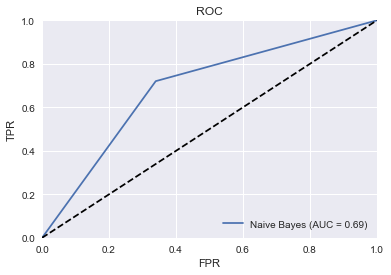

In [11]:
nb = BernoulliNB()
nb.fit(trainX[features], trainY['over90'])
nb_preds=nb.predict(testX[features])
print(nb.score(testX[features],testY['over90']))
plotAUC(testY['over90'],nb.predict(testX[features]),'Naive Bayes')

### Logistic Regression

C:\Users\da1933\AppData\Local\Continuum\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


0.7248843004627982


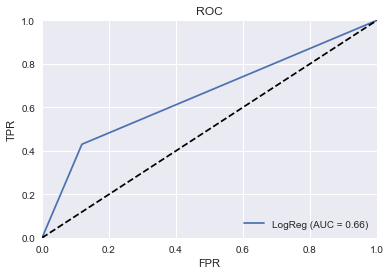

In [12]:
lr = LogisticRegression()
lr.fit(trainX[features],trainY['over90'])
lr_preds=lr.predict(testX[features])
print(lr.score(testX[features],testY['over90']))
plotAUC(testY['over90'],lr.predict(testX[features]),'LogReg')

### KNN

0.762993948024208


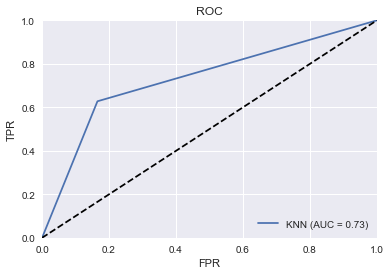

In [13]:
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(trainX[features],trainY['over90'])
knn_preds=knn.predict(testX[features])
print(knn.score(testX[features],testY['over90']))
plotAUC(testY['over90'],knn.predict(testX[features]),'KNN')

### Decision Tree

0.7903524385902456


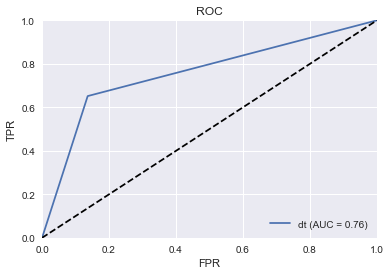

In [14]:
dt=DecisionTreeClassifier()
dt.fit(trainX[features],trainY['over90'])
dt_preds=dt.predict(testX[features])
print(dt.score(testX[features],testY['over90']))
plotAUC(testY['over90'],dt.predict(testX[features]),'dt')

### Random Forest Classifier

C:\Users\da1933\AppData\Local\Continuum\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


0.7946778212887149


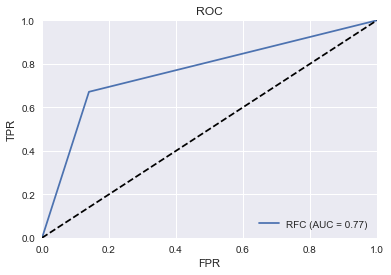

In [15]:
rfc=RandomForestClassifier(criterion='entropy')
rfc.fit(trainX[features],trainY['over90'])
rfc_preds=rfc.predict(testX[features])
print(rfc.score(testX[features],testY['over90']))
plotAUC(testY['over90'],rfc.predict(testX[features]),'RFC')

### Gradient Boosted Classifier

0.7548059807760769


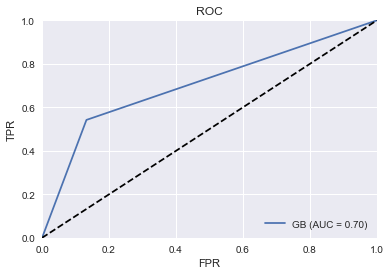

In [16]:
gbc=GradientBoostingClassifier()
gbc.fit(trainX[features],trainY['over90'])
gbc_preds=gbc.predict(testX[features])
print(gbc.score(testX[features],testY['over90']))
plotAUC(testY['over90'],gbc.predict(testX[features]),'GB')

### To add later ? Analyze how/why models' predictions are different?

In [17]:
print('NB and LR make {0:.2f}% similar predictions'.format(100*sum(nb_preds==lr_preds)/len(testY['over90'])))
print('NB and KNN make {0:.2f}% similar predictions'.format(100*sum(nb_preds==knn_preds)/len(testY['over90'])))
print('NB and DT make {0:.2f}% similar predictions'.format(100*sum(nb_preds==dt_preds)/len(testY['over90'])))
print('NB and RFC make {0:.2f}% similar predictions'.format(100*sum(nb_preds==rfc_preds)/len(testY['over90'])))
print('NB and GBC make {0:.2f}% similar predictions'.format(100*sum(nb_preds==gbc_preds)/len(testY['over90'])))
print('LR and KNN make {0:.2f}% similar predictions'.format(100*sum(lr_preds==knn_preds)/len(testY['over90'])))
print('LR and DT make {0:.2f}% similar predictions'.format(100*sum(lr_preds==dt_preds)/len(testY['over90'])))
print('LR and RFC make {0:.2f}% similar predictions'.format(100*sum(lr_preds==rfc_preds)/len(testY['over90'])))
print('LR and GBC make {0:.2f}% similar predictions'.format(100*sum(lr_preds==gbc_preds)/len(testY['over90'])))
print('KNN and DT make {0:.2f}% similar predictions'.format(100*sum(knn_preds==dt_preds)/len(testY['over90'])))
print('KNN and RFC make {0:.2f}% similar predictions'.format(100*sum(knn_preds==rfc_preds)/len(testY['over90'])))
print('KNN and GBT make {0:.2f}% similar predictions'.format(100*sum(knn_preds==gbc_preds)/len(testY['over90'])))
print('DT and RFC make {0:.2f}% similar predictions'.format(100*sum(dt_preds==rfc_preds)/len(testY['over90'])))
print('DT and GBC make {0:.2f}% similar predictions'.format(100*sum(dt_preds==gbc_preds)/len(testY['over90'])))
print('RFC and GBC make {0:.2f}% similar predictions'.format(100*sum(rfc_preds==gbc_preds)/len(testY['over90'])))

NB and LR make 75.54% similar predictions
NB and KNN make 71.50% similar predictions
NB and DT make 72.23% similar predictions
NB and RFC make 72.89% similar predictions
NB and GBC make 77.38% similar predictions
LR and KNN make 76.04% similar predictions
LR and DT make 77.25% similar predictions
LR and RFC make 77.30% similar predictions
LR and GBC make 87.43% similar predictions
KNN and DT make 86.78% similar predictions
KNN and RFC make 87.21% similar predictions
KNN and GBT make 80.87% similar predictions
DT and RFC make 95.49% similar predictions
DT and GBC make 81.88% similar predictions
RFC and GBC make 82.36% similar predictions


# Regression

### Random Forest Regression

In [ ]:
clf=RandomForestRegressor()
clf.fit(trainX[features],trainY['points'])
score=clf.score(testX[features],testY['points'])

In [ ]:
scores=[]
d=[50,300]
l=[5,10]
for depth in d:
    for leaves in l:
        clf=RandomForestRegressor(max_depth=depth,min_samples_leaf=leaves)
        clf.fit(trainX[['enc_province','enc_variety','textlen']],trainY['points'])
        score=clf.score(testX[['enc_province','enc_variety','textlen']],testY['points'])
        scores.append((depth,leaves,score))
        print(depth,leaves,score)